In [1]:
import tensorflow as tf
from tensorflow import keras as K

import numpy as np
import pandas as pd
import math

from tensorflow.keras.layers import Conv2D,Conv2DTranspose,MaxPool2D,Input,concatenate,Lambda,ReLU,Activation,BatchNormalization
# from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import Sequence
from tensorflow.keras.activations import relu,sigmoid
from tensorflow.keras.losses import Loss
from tensorflow.keras.backend import epsilon
from tensorflow.keras.optimizers import Nadam,Adam,RMSprop,SGD
from PIL import Image
import os
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import array_to_img,img_to_array,load_img
from matplotlib import pyplot as plt
from tqdm import tqdm
from time import time
from tensorflow.keras import backend
from tensorflow.keras.metrics import AUC

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [3]:
tf.test.is_built_with_cuda()

False

In [4]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
PARENT_DIR = os.path.abspath('../DFU Dataset details/DFUC2022_train/DFUC2022_train_release/')
DATA_DIR = os.path.abspath('../DFU Dataset details/DFUC2022_train/DFUC2022_train_release/DFUC2022_train_images')
MASK_DIR = os.path.abspath('../DFU Dataset details/DFUC2022_train/DFUC2022_train_release/DFUC2022_train_masks')
BATCH_SIZE = 32
HEIGHT = 256
WIDTH = 256
NUM_TEST_DATA = 200
CHANNELS = 3 #RGB
INITIAL_FILTER_SIZE = 16

In [7]:
data_filenames = [name for name in os.listdir(DATA_DIR) if name.endswith('.jpg')]
mask_filenames = [name for name in os.listdir(MASK_DIR) if name.endswith('.png')]

#data and mask same names except extensions
file_names = [name[:-4] for name in os.listdir(DATA_DIR) if name.endswith('.jpg')]

In [8]:
# ax= mask_filenames[0]
# ax = np.around(img_to_array(load_img(os.path.join(MASK_DIR,mask_filenames[0])))/255)

# bx = list()
# for h in range(HEIGHT):
#     for w in  range(WIDTH):
#         bx.append(str(ax[h,w,:])) 

# np.unique(bx)

In [9]:
# np.around(np.sum(np.ones((3,4,2)),axis=2)/2)
# #np.around(np.sum(np.ones((3,4,2)),axis=2)/2).reshape(3,4,1)

In [10]:
class CustomGenerator(Sequence):
    def  __init__(self,file_names,classes=None,batch_size=64):
        self.file_names = file_names
        self.batch_size = batch_size
        self.classes = classes

    def __len__(self):
        return len(self.file_names)//self.batch_size

    def get_image(self,image_path):
        IMAGE_PATH = os.path.join(DATA_DIR,(image_path+'.jpg'))
        arr = img_to_array(load_img(IMAGE_PATH,target_size=(HEIGHT,WIDTH)))/255.0

        if self.classes == None:
            return  arr

        MASK_PATH = os.path.join(MASK_DIR,(image_path+'.png'))

        #loading mask array from mask path
        mask = img_to_array(load_img(MASK_PATH,target_size=(HEIGHT,WIDTH)))/255.0
        #making mask B&W by rounding off
        # mask = np.around(mask)
        #adding up RGB values([1,1,1]:WHITE,[0,0,0]:BLACK) and rounding off 
        mask = np.around(np.sum(mask,axis=2)/3)
        mask = mask.astype('float32')
        ##mask = np.sum(mask,axis=2)/3
        #adding a 3rd dimension for 0 or 1 value of pixel
        mask = mask.reshape(HEIGHT,WIDTH,1)

        # mask = tf.image.resize(tf.io.decode_image(tf.io.read_file(MASK_PATH)),(HEIGHT,WIDTH))

        return arr,mask#.numpy().reshape(HEIGHT,WIDTH,1)
    
    def __getitem__(self,idx):
        batch = self.file_names[idx*self.batch_size:(idx+1)*self.batch_size]
        images = list()
        labels = list()
        for image_path in batch:
            if self.classes != None:
                image,label = self.get_image(image_path)
                images.append(image)
                labels.append(label)
            else:
                image = self.get_image(image_path)
                images.append(image)
            
        if self.classes != None:
            return np.asarray(images,dtype=np.float32),np.asarray(labels,dtype=np.float32)
        else:
            return np.asarray(images,dtype=np.float32)


In [11]:
# class DerivedGenerator(Sequence):
#     def  __init__(self,file_names,classes=None,batch_size=64):
#         self.file_names = file_names
#         self.batch_size = batch_size
#         self.classes = classes

#     def __len__(self):
#         return len(self.file_names)//self.batch_size

#     def get_image(self,image_path):
#         IMAGE_PATH = os.path.join(DATA_DIR,(image_path+'.jpg'))
#         img = tf.io.read_file(IMAGE_PATH)
#         img = tf.io.decode_image(img)
#         img = tf.image.resize(img,(HEIGHT,WIDTH))

#         arr = img[:,:,:3].numpy()
#         new_arr = (arr - arr.min())*(1/(arr.max() - arr.min()))

#         if self.classes == None:
#             return  new_arr

#         MASK_PATH = os.path.join(MASK_DIR,(image_path+'.png'))

#         mask_ = tf.zeros(shape=(HEIGHT,WIDTH,1))
#         mask = tf.io.read_file(MASK_PATH)
#         mask = tf.io.decode_image(mask)
#         mask = tf.image.resize(mask,(HEIGHT,WIDTH))

#         mask_ = tf.maximum(mask_,mask)

#         return new_arr,mask_.numpy()
    
#     def __getitem__(self,idx):
#         batch = self.file_names[idx*self.batch_size:(idx+1)*self.batch_size]
#         images = list()
#         labels = list()
#         for image_path in batch:
#             if self.classes != None:
#                 image,label = self.get_image(image_path)
#                 images.append(image)
#                 labels.append(label/255.0)
#             else:
#                 image = self.get_image(image_path)
#                 images.append(image)
            
#         if self.classes != None:
#             return tf.convert_to_tensor(np.array(images),dtype='float32'),tf.convert_to_tensor(np.array(labels),dtype='float32')
#         else:
#             return tf.convert_to_tensor(np.array(images),dtype='float32')


In [12]:
train_file_names,val_file_names = train_test_split(file_names[:len(file_names)-NUM_TEST_DATA],train_size=0.8,shuffle=False)
test_file_names = file_names[len(file_names)-NUM_TEST_DATA:]

In [13]:
train_datagen = CustomGenerator(train_file_names,2,BATCH_SIZE)
val_datagen = CustomGenerator(val_file_names,2,BATCH_SIZE)
test_datagen = CustomGenerator(file_names[len(file_names)-NUM_TEST_DATA:],2,BATCH_SIZE)

In [14]:
# train_images = []
# train_labels = []

# val_images = []
# val_labels = []

# test_images = []

# def get_image(image_path,classes):
#     IMAGE_PATH = os.path.join(DATA_DIR,(image_path+'.jpg'))
#     arr = img_to_array(load_img(IMAGE_PATH,target_size=(HEIGHT,WIDTH)))/255.0

#     if classes == None:
#         return  arr

#     MASK_PATH = os.path.join(MASK_DIR,(image_path+'.png'))
#     #loading mask array from mask path
#     mask = img_to_array(load_img(MASK_PATH,target_size=(HEIGHT,WIDTH)))/255.0
#     #making mask B&W by rounding off
#     mask = np.around(mask)
#     #adding up RGB values([1,1,1]:WHITE,[0,0,0]:BLACK) and rounding off 
#     mask = np.around(np.sum(mask,axis=2)/3)
#     #adding a 3rd dimension for 0 or 1 value of pixel
#     mask = mask.reshape(HEIGHT,WIDTH,1)

#     return arr,mask

# for image_path in tqdm(train_file_names):
#     image,label = get_image(image_path,classes=2)
#     train_images.append(image)
#     train_labels.append(label)

# for image_path in tqdm(val_file_names):
#     image,label = get_image(image_path,classes=2)
#     val_images.append(image)
#     val_labels.append(label)

# for image_path in tqdm(test_file_names):
#     image = get_image(image_path,classes=None)
#     test_images.append(image)

# train_tensorgen = tf.data.Dataset.from_tensor_slices((train_images,train_labels))
# train_tensorgen = train_tensorgen.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

# val_tensorgen = tf.data.Dataset.from_tensor_slices((val_images,val_labels))
# val_tensorgen = val_tensorgen.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [15]:
# images = []
# labels = []


# for (image_batch,label_batch) in tqdm(train_datagen):
#     images.extend(image_batch)
#     labels.extend(label_batch)

# train_tensorgen = tf.data.Dataset.from_tensor_slices((images,labels))
# train_tensorgen = train_tensorgen.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [16]:
@tf.custom_gradient
def round_with_gradients(x):
    def grad(dy):
        return dy
    return tf.round(x), grad

def get_model(HEIGHT,WIDTH,CHANNELS):

    inputs = Input(shape=(HEIGHT,WIDTH,CHANNELS,))
    conv_1 = Conv2D(filters=INITIAL_FILTER_SIZE,kernel_size = 3,padding = 'same')(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation('relu')(conv_1)
    conv_1 = Conv2D(filters=INITIAL_FILTER_SIZE,kernel_size = 3,padding = 'same')(conv_1)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation('relu')(conv_1)

    conv_2 = MaxPool2D(pool_size=2)(conv_1)
    conv_2 = Conv2D(filters=INITIAL_FILTER_SIZE*2,kernel_size=3,padding='same')(conv_2)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation('relu')(conv_2)
    conv_2 = Conv2D(filters=INITIAL_FILTER_SIZE*2,kernel_size=3,padding='same')(conv_2)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation('relu')(conv_2)

    conv_3 = MaxPool2D(pool_size=2)(conv_2)
    conv_3 = Conv2D(filters=INITIAL_FILTER_SIZE*4,kernel_size=3,padding='same')(conv_3)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation('relu')(conv_3)
    conv_3 = Conv2D(filters=INITIAL_FILTER_SIZE*4,kernel_size=3,padding='same')(conv_3)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation('relu')(conv_3)

    conv_4 = MaxPool2D(pool_size=2)(conv_3)
    conv_4 = Conv2D(filters=INITIAL_FILTER_SIZE*8,kernel_size=3,padding='same')(conv_4)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation('relu')(conv_4)
    conv_4 = Conv2D(filters=INITIAL_FILTER_SIZE*8,kernel_size=3,padding='same')(conv_4)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation('relu')(conv_4)

    conv_5 = MaxPool2D(pool_size=2)(conv_4)
    conv_5 = Conv2D(filters=INITIAL_FILTER_SIZE*16,kernel_size=3,padding='same')(conv_5)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation('relu')(conv_5)
    conv_5 = Conv2D(filters=INITIAL_FILTER_SIZE*16,kernel_size=3,padding='same')(conv_5)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation('relu')(conv_5)

    conv_6 = Conv2DTranspose(filters=INITIAL_FILTER_SIZE*8,kernel_size=2,strides=2,padding='same')(conv_5)
    conv_6 = concatenate([conv_4,conv_6])
    conv_6 = Conv2D(filters=INITIAL_FILTER_SIZE*8,kernel_size=3,padding='same')(conv_6)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation('relu')(conv_6)
    conv_6 = Conv2D(filters=INITIAL_FILTER_SIZE*8,kernel_size=3,padding='same')(conv_6)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation('relu')(conv_6)

    conv_7 = Conv2DTranspose(filters=INITIAL_FILTER_SIZE*4,kernel_size=2,strides=2,padding='same')(conv_6)
    conv_7 = concatenate([conv_3,conv_7])
    conv_7 = Conv2D(filters=INITIAL_FILTER_SIZE*4,kernel_size=3,padding='same')(conv_7)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation('relu')(conv_7)
    conv_7 = Conv2D(filters=INITIAL_FILTER_SIZE*4,kernel_size=3,padding='same')(conv_7)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation('relu')(conv_7)

    conv_8 = Conv2DTranspose(filters=INITIAL_FILTER_SIZE*2,kernel_size=2,strides=2,padding='same')(conv_7)
    conv_8 = concatenate([conv_2,conv_8])
    conv_8 = Conv2D(filters=INITIAL_FILTER_SIZE*2,kernel_size=3,padding='same')(conv_8)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation('relu')(conv_8)
    conv_8 = Conv2D(filters=INITIAL_FILTER_SIZE*2,kernel_size=3,padding='same')(conv_8)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation('relu')(conv_8)

    conv_9 = Conv2DTranspose(filters=INITIAL_FILTER_SIZE,kernel_size=2,strides=2,padding='same')(conv_8)
    conv_9 = concatenate([conv_1,conv_9])
    conv_9 = Conv2D(filters=INITIAL_FILTER_SIZE,kernel_size=3,padding='same')(conv_9)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation('relu')(conv_9)
    conv_9 = Conv2D(filters=INITIAL_FILTER_SIZE,kernel_size=3,padding='same')(conv_9)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation('relu')(conv_9)

    output = Conv2D(filters=1,kernel_size=3,padding='same',activation=sigmoid)(conv_9)


    # output = Activation(round_with_gradients)(output)

    model = Model(inputs=inputs,outputs=output)

    return model


In [17]:
model = get_model(HEIGHT,WIDTH,CHANNELS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
class MeanSquaredError(Loss):

  def call(self, y_true, y_pred):
    return tf.reduce_mean(tf.math.square(y_pred - y_true), axis=-1)
#(pred_img_arr[i]>0.5).astype('uint8')

class BinaryCrossEntropy(Loss):
  def call(self,y_true,y_pred):
    # y_pred = tf.cast((y_pred>0.5),dtype=tf.float32)
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    term_0 = (1 - y_true) * tf.math.log(1 - y_pred + tf.keras.backend.epsilon())  
    term_1 = y_true * tf.math.log(y_pred + tf.keras.backend.epsilon())
    return -tf.reduce_mean(term_0 + term_1, axis=0)


class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1 - tf.divide(nominator, denominator)
        return result

def dice_coef(y_true,y_pred,smooth=1e-6,gama=3):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + smooth
        denominator = tf.reduce_sum(
            y_pred) + tf.reduce_sum(y_true) + smooth
        result = tf.divide(nominator, denominator)
        return result

def dice_coef_loss(y_true,y_pred):
    return 1-dice_coef(y_true,y_pred)

def tversky_index(y_true,y_pred,smooth=1e-6,alpha=0.7,beta=0.3):
    y_true = tf.cast(y_true,dtype=tf.float32)
    y_pred = tf.cast(y_pred,dtype=tf.float32)
    numerator = tf.reduce_sum(tf.multiply(y_true,y_pred)) + smooth
    denominator = tf.reduce_sum(tf.multiply(y_pred,y_true)) +  \
        alpha*tf.reduce_sum(tf.multiply(1-y_pred,y_true)) + \
            beta*tf.reduce_sum(tf.multiply(y_pred,1-y_true)) + \
                smooth
    return numerator/denominator

def tversky_loss(y_true,y_pred):
    return 1 - tversky_index(y_true,y_pred)

def FTL(y_true,y_pred,gamma = 1.33):
    return tversky_loss(y_true,y_pred)**(1/gamma)

def wsd_loss(y_true,y_pred,smooth=1e-6,v1=0.1,v2=0.9):
    y_true = tf.cast(y_true,dtype=tf.float32)
    y_pred = tf.cast(y_pred,dtype=tf.float32)

    y_true_mod = 2*y_true - 1
    y_pred_mod = 2*y_pred - 1

    W = y_true*(v2-v1) + v1
    numerator = 2*tf.multiply(
        tf.multiply(W,2*y_true - 1),
        tf.multiply(W,2*y_pred - 1)
    ) + smooth
    denominator = tf.reduce_sum(tf.multiply(W,2*y_true - 1)) + \
        tf.reduce_sum(tf.multiply(W,2*y_pred - 1)) + \
            smooth
    return 1 - numerator/denominator


In [19]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)
model.compile(optimizer=Adam(),loss=FTL,metrics=[dice_coef, AUC(),tversky_index])

In [20]:
NUM_EPOCHS = 30

history = model.fit(train_datagen,validation_data=val_datagen,epochs=NUM_EPOCHS)

Epoch 1/30
45/45 [==============================] - 162s 4s/step - loss: 0.8731 - dice_coef: 0.1079 - auc: 0.9101 - dice_coef_loss: 0.8921 - tversky_index: 0.1644 - val_loss: 0.9446 - val_dice_coef: 0.0481 - val_auc: 0.7731 - val_dice_coef_loss: 0.9519 - val_tversky_index: 0.0729
Epoch 2/30
45/45 [==============================] - 132s 3s/step - loss: 0.7219 - dice_coef: 0.2591 - auc: 0.9145 - dice_coef_loss: 0.7409 - tversky_index: 0.3492 - val_loss: 0.9407 - val_dice_coef: 0.0485 - val_auc: 0.5099 - val_dice_coef_loss: 0.9515 - val_tversky_index: 0.0780
Epoch 3/30
45/45 [==============================] - 135s 3s/step - loss: 0.5653 - dice_coef: 0.4536 - auc: 0.8984 - dice_coef_loss: 0.5464 - tversky_index: 0.5293 - val_loss: 0.9319 - val_dice_coef: 0.0558 - val_auc: 0.5947 - val_dice_coef_loss: 0.9442 - val_tversky_index: 0.0894
Epoch 4/30
45/45 [==============================] - 160s 4s/step - loss: 0.5177 - dice_coef: 0.5191 - auc: 0.8907 - dice_coef_loss: 0.4809 - tversky_index: 0

In [31]:
# models_saved = os.listdir('../Saved_Models').__len__()
# model.save('../Saved_Models/Model_'+str(models_saved))

INFO:tensorflow:Assets written to: ../Saved_Models/Model_7\assets


In [22]:
model.evaluate(test_datagen)

6/6 [==============================] - 5s 789ms/step - loss: 0.3847 - dice_coef: 0.6884 - auc: 0.8932 - dice_coef_loss: 0.3116 - tversky_index: 0.7176


[0.38471975922584534,
 0.6883864998817444,
 0.8932125568389893,
 0.3116134703159332,
 0.7176364064216614]

In [23]:
pred_img_arr = model.predict(test_datagen)

In [24]:
# np.random.seed(0)
# sample_test_image_idx = np.random.choice(200,size=5,replace=False)


# for i in sample_test_image_idx:
#     img_ = img_to_array(load_img(os.path.join(DATA_DIR,(test_file_names[i]+'.jpg'))))/255.0
#     MASK_PATH = os.path.join(MASK_DIR,(test_file_names[i]+'.png'))

#     mask = img_to_array(load_img(MASK_PATH,target_size=(HEIGHT,WIDTH)))/255.0
#     mask = np.around(np.sum(mask,axis=2)/3)

#     mask = mask.reshape(HEIGHT,WIDTH,1)

#     plt.figure(figsize=(15,7))
#     plt.subplot(1,3,1)
#     plt.imshow(img_)
#     plt.subplot(1,3,2)
#     plt.imshow(mask)
#     plt.subplot(1,3,3)
#     plt.imshow((pred_img_arr[i]>0.5).astype('float32'))
#     # plt.imshow(pred_img_arr[i])
#     plt.show()

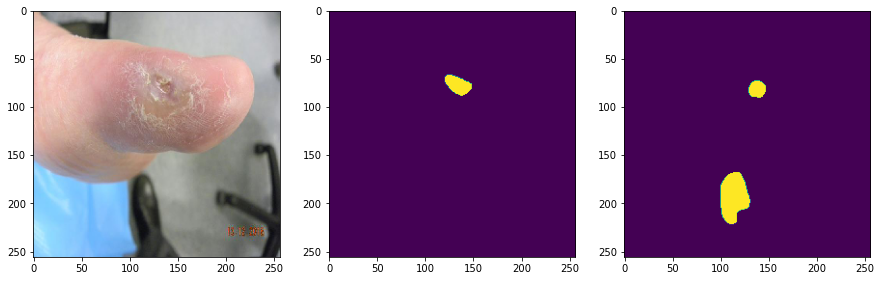

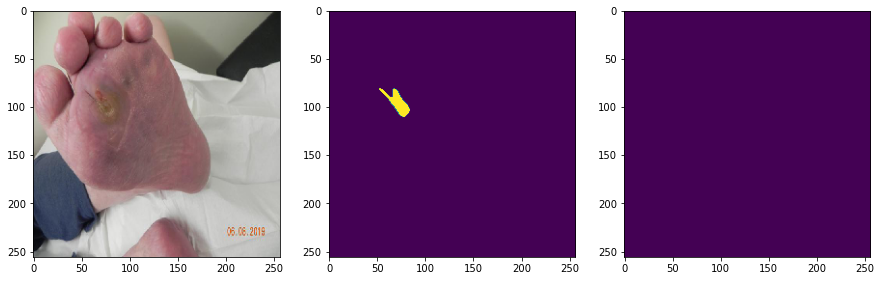

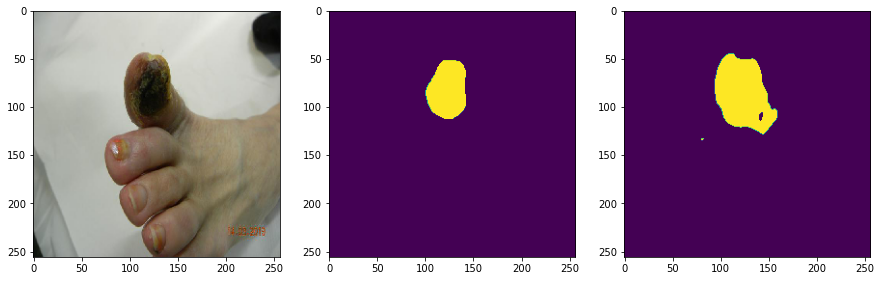

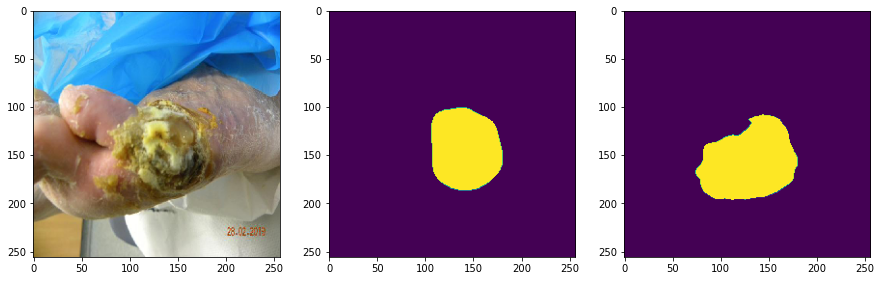

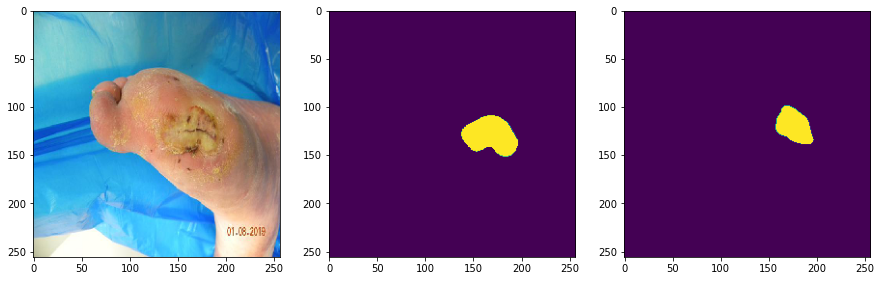

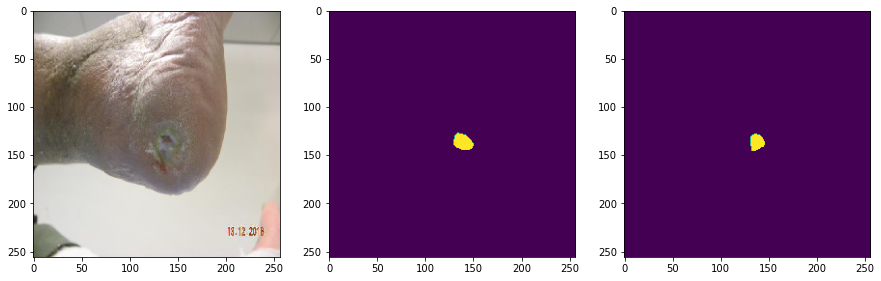

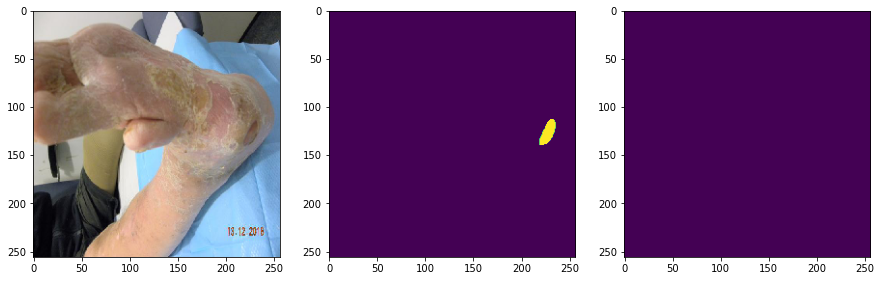

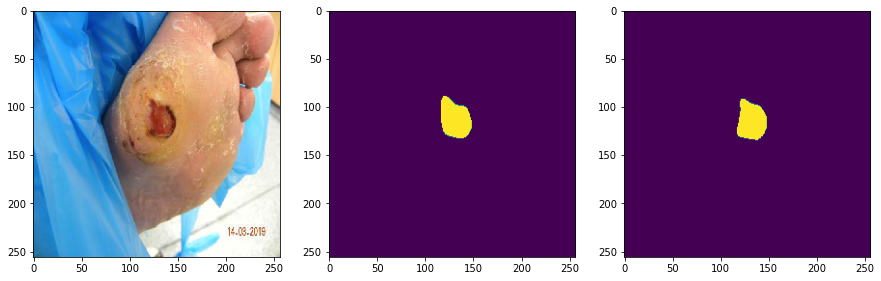

In [25]:

#np.random.seed(8)
sample_test_images = np.random.choice(192,size=8,replace=False)


for sample_test_image_idx in sample_test_images:
    img_ = img_to_array(load_img(os.path.join(DATA_DIR,(test_file_names[sample_test_image_idx]+'.jpg')),target_size=(HEIGHT,WIDTH)))/255.0
    MASK_PATH = os.path.join(MASK_DIR,(test_file_names[sample_test_image_idx]+'.png'))

    mask = img_to_array(load_img(MASK_PATH,target_size=(HEIGHT,WIDTH)))/255.0
    mask = np.around(np.sum(mask,axis=2)/3)

    mask = mask.reshape(HEIGHT,WIDTH,1)

    plt.figure(figsize=(15,7))
    plt.subplot(1,3,1)
    plt.imshow(img_)
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.subplot(1,3,3)
    plt.imshow((pred_img_arr[sample_test_image_idx]>0.5).astype('float32'))
    # plt.imshow(pred_img_arr[i])
    plt.show()


In [26]:
pred_img_arr.shape

(192, 256, 256, 1)

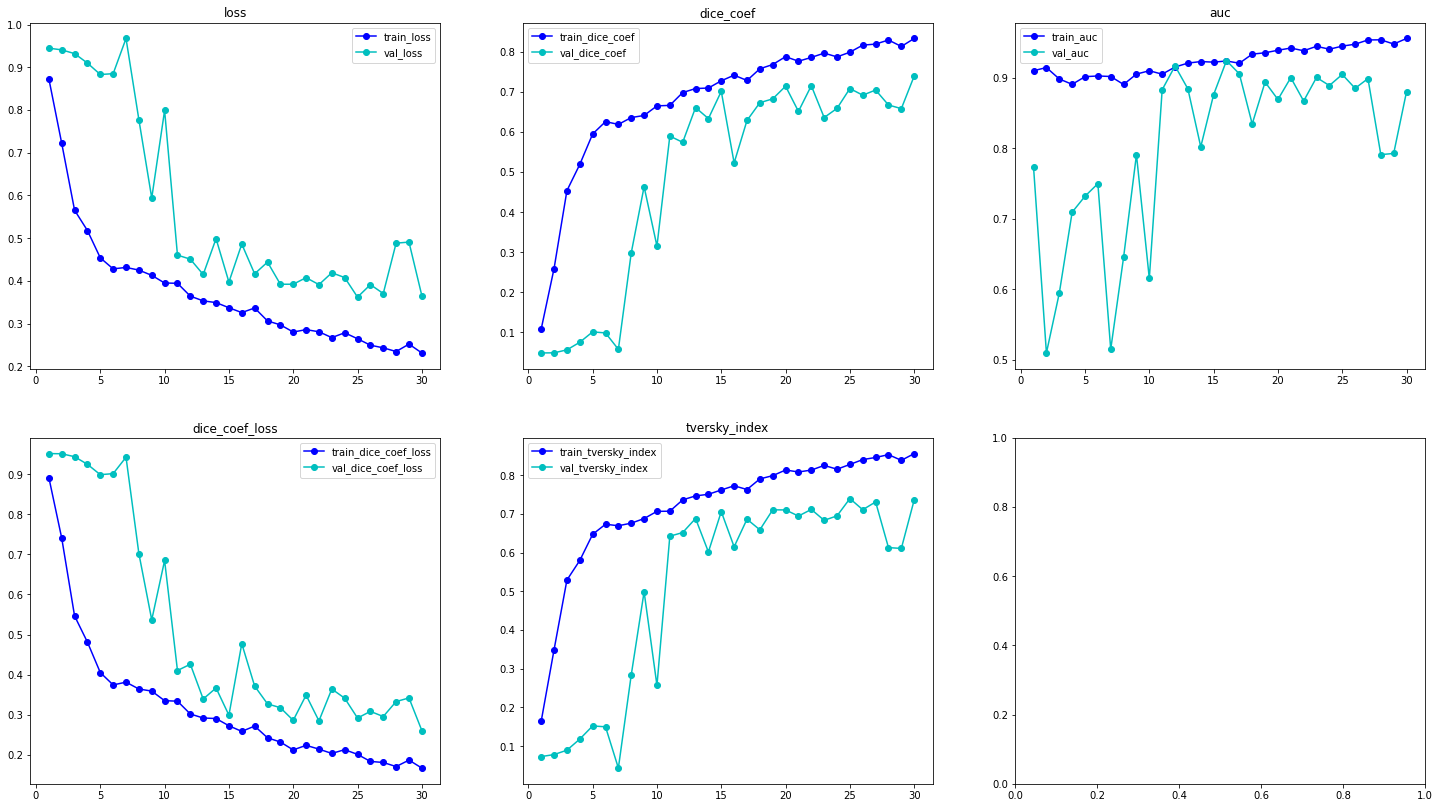

In [27]:
epoch_idx = list(range(1,NUM_EPOCHS+1))

plot_metrics = list(history.history.keys())
num_keys = len(plot_metrics)
plot_metrics = list(zip(plot_metrics[:num_keys//2],plot_metrics[num_keys//2:]))

num_subplots = plot_metrics.__len__()
fig,ax = plt.subplots(nrows=math.ceil(num_subplots/3.0),ncols=3,figsize = (25,math.ceil(num_subplots/3)*7))

for idx,[metric,val_metric] in enumerate(plot_metrics):
    ax[idx//3,idx%3].set_title(metric)
    ax[idx//3,idx%3].plot(epoch_idx,history.history[metric],'bo-',label='train_'+metric)
    ax[idx//3,idx%3].plot(epoch_idx,history.history[val_metric],'co-',label=val_metric)
    ax[idx//3,idx%3].legend()

plt.show()


In [28]:
math.ceil(num_subplots/3.0)

2

In [29]:
print(plot_metrics)

[('loss', 'val_loss'), ('dice_coef', 'val_dice_coef'), ('auc', 'val_auc'), ('dice_coef_loss', 'val_dice_coef_loss'), ('tversky_index', 'val_tversky_index')]


In [30]:
import pandas as pd